In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from scipy.stats import boxcox
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


In [24]:
# read the csv
df = pd.read_csv('C:/Users/aliek/Desktop/ANN_Paper_Project/heart.csv')

In [25]:
# Define the continuous features
continuous_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

# Identify the features to be converted to object data type
features_to_convert = [feature for feature in df.columns if feature not in continuous_features]

# Convert the identified features to object data type
df[features_to_convert] = df[features_to_convert].astype('object')

df.dtypes

age           int64
sex          object
cp           object
trestbps      int64
chol          int64
fbs          object
restecg      object
thalach       int64
exang        object
oldpeak     float64
slope        object
ca           object
thal         object
target       object
dtype: object

In [26]:
# Get the summary statistics for categorical variables
df.describe(include='object')

,sex,cp,fbs,restecg,exang,slope,ca,thal,target
count,303,303,303,303,303,303,303,303,303
unique,2,4,2,3,2,3,5,4,2
top,1,0,0,1,0,2,0,2,1
freq,207,143,258,152,204,142,175,166,165


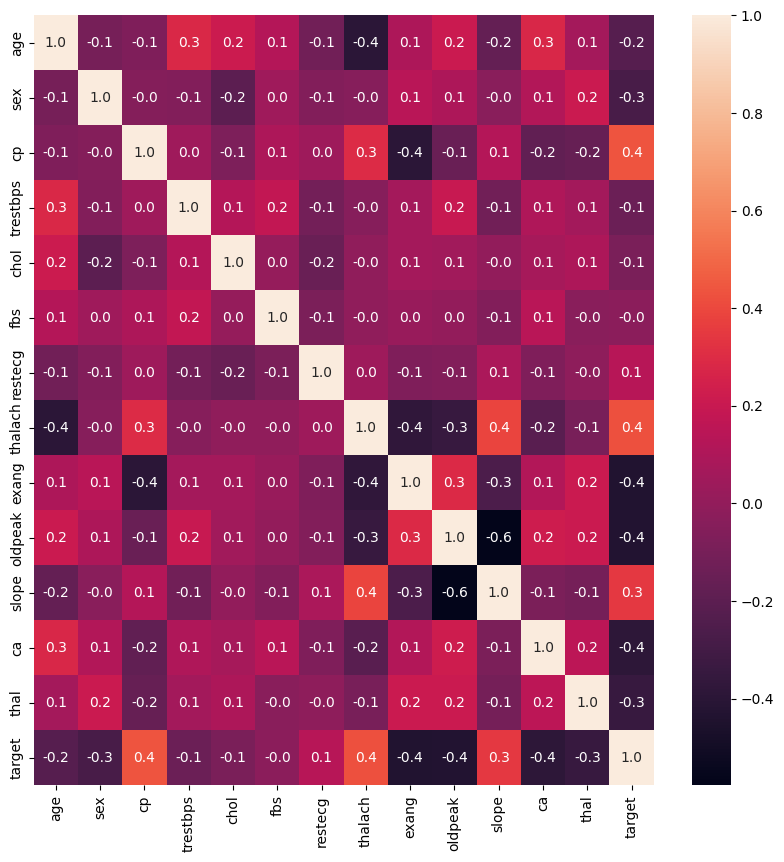

In [27]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(),annot=True,fmt='.1f')
plt.show()

In [28]:
# Filter out categorical features for the univariate analysis
categorical_features = df.columns.difference(continuous_features)
df_categorical = df[categorical_features]

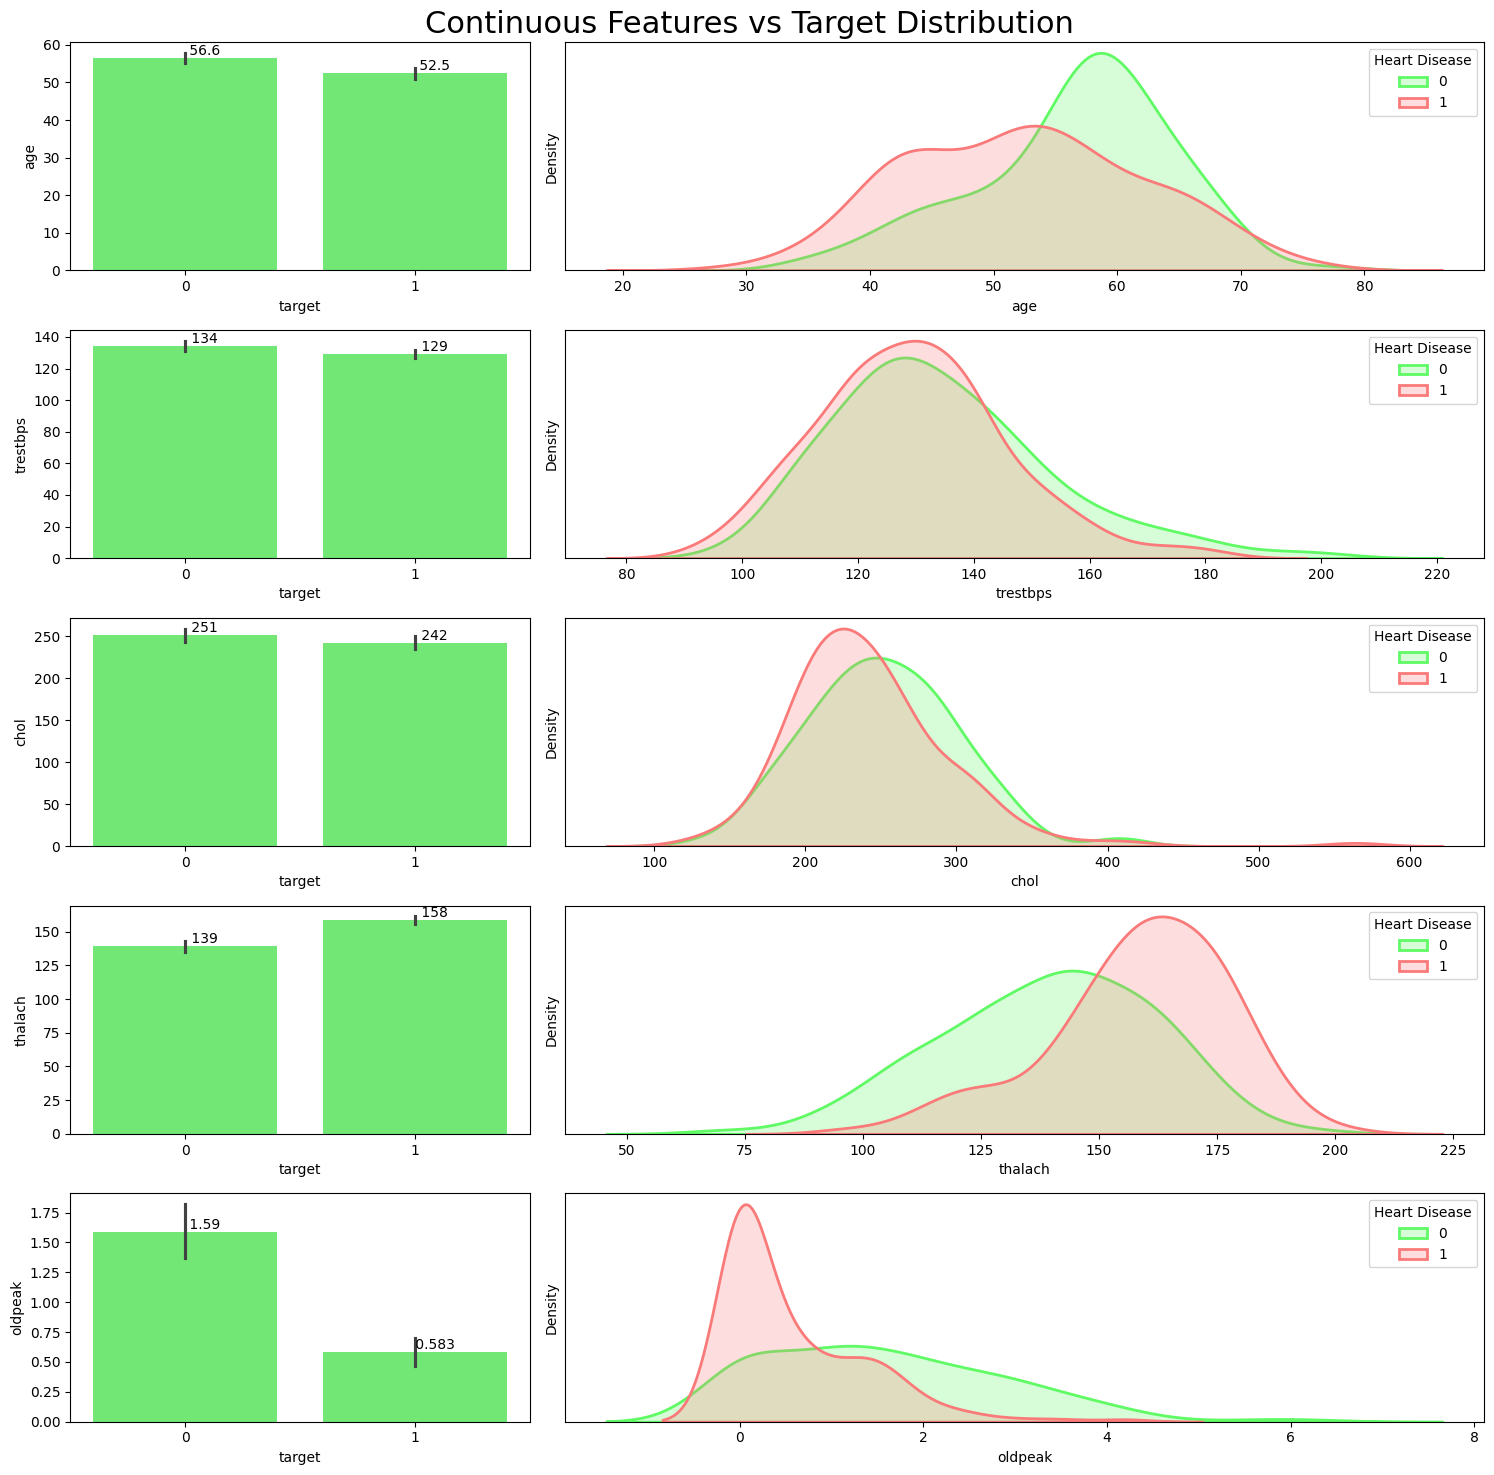

In [29]:
# Set color palette
sns.set_palette(['#5ffa64', '#fa7a7a'])

# Create the subplots
fig, ax = plt.subplots(len(continuous_features), 2, figsize=(15,15), gridspec_kw={'width_ratios': [1, 2]})

# Loop through each continuous feature to create barplots and kde plots
for i, col in enumerate(continuous_features):
    # Barplot showing the mean value of the feature for each target category
    graph = sns.barplot(data=df, x="target", y=col, ax=ax[i,0])
    
    # KDE plot showing the distribution of the feature for each target category
    sns.kdeplot(data=df[df["target"]==0], x=col, fill=True, linewidth=2, ax=ax[i,1], label='0')
    sns.kdeplot(data=df[df["target"]==1], x=col, fill=True, linewidth=2, ax=ax[i,1], label='1')
    ax[i,1].set_yticks([])
    ax[i,1].legend(title='Heart Disease', loc='upper right')
    
    # Add mean values to the barplot
    for cont in graph.containers:
        graph.bar_label(cont, fmt='         %.3g')
        
# Set the title for the entire figure
plt.suptitle('Continuous Features vs Target Distribution', fontsize=22)
plt.tight_layout()                     
plt.show()

In [30]:
# Remove 'target' from the categorical_features
categorical_features = [feature for feature in categorical_features if feature != 'target']

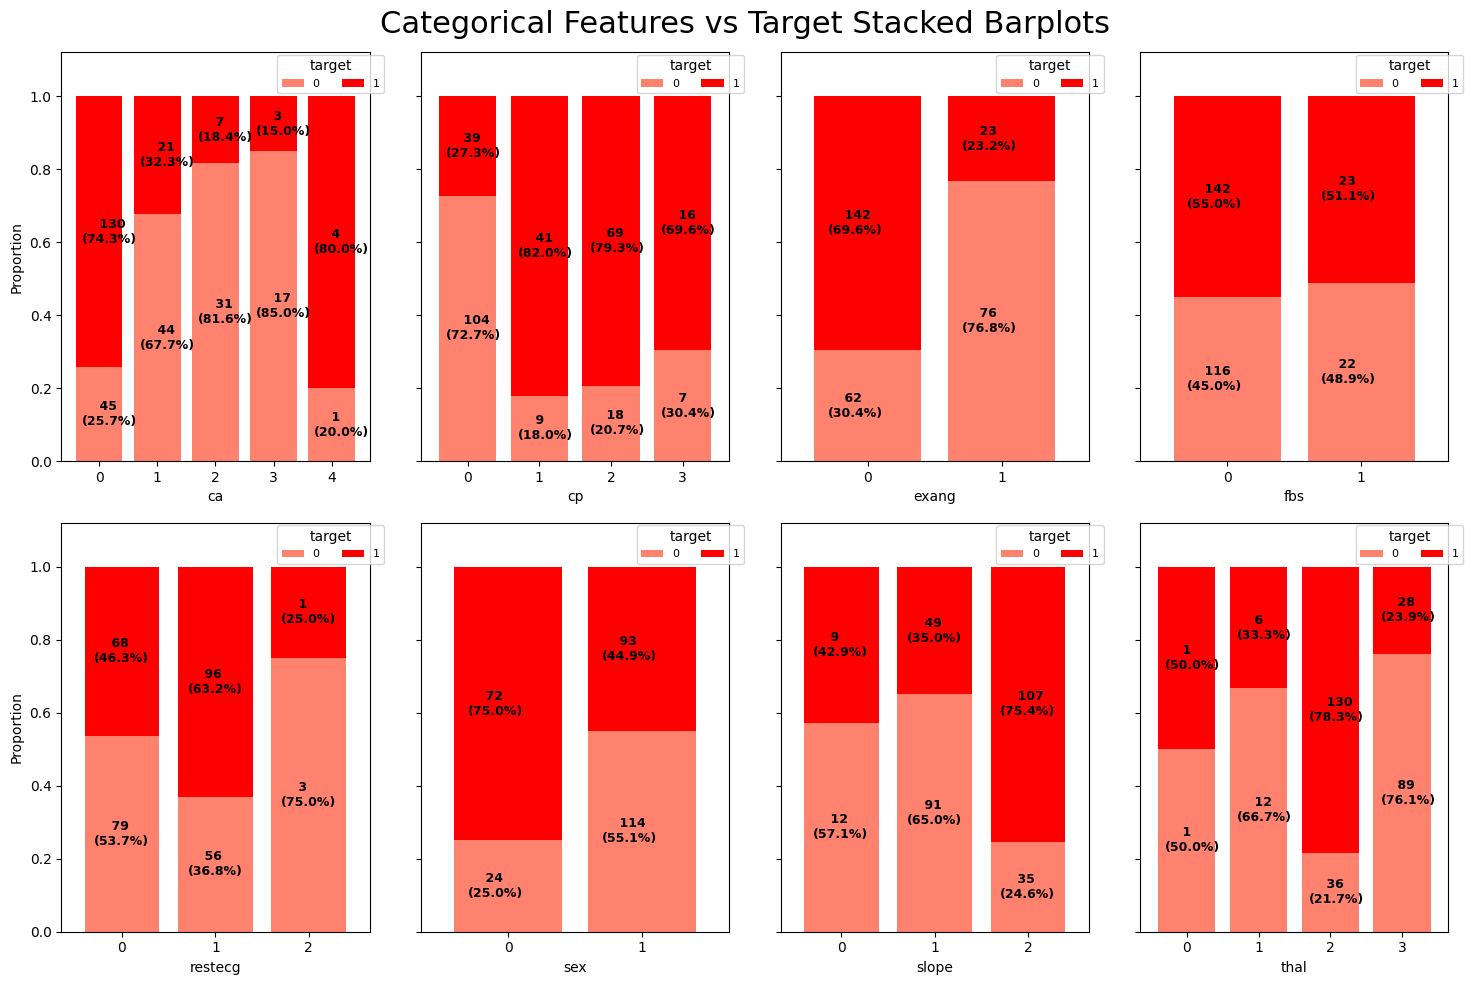

In [31]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15,10))

for i,col in enumerate(categorical_features):
    
    # Create a cross tabulation showing the proportion of purchased and non-purchased loans for each category of the feature
    cross_tab = pd.crosstab(index=df[col], columns=df['target'])
    
    # Using the normalize=True argument gives us the index-wise proportion of the data
    cross_tab_prop = pd.crosstab(index=df[col], columns=df['target'], normalize='index')

    # Define colormap
    cmp = ListedColormap(['#ff826e', 'red'])
    
    # Plot stacked bar charts
    x, y = i//4, i%4
    cross_tab_prop.plot(kind='bar', ax=ax[x,y], stacked=True, width=0.8, colormap=cmp,
                        legend=False, ylabel='Proportion', sharey=True)
    
    # Add the proportions and counts of the individual bars to our plot
    for idx, val in enumerate([*cross_tab.index.values]):
        for (proportion, count, y_location) in zip(cross_tab_prop.loc[val],cross_tab.loc[val],cross_tab_prop.loc[val].cumsum()):
            ax[x,y].text(x=idx-0.3, y=(y_location-proportion)+(proportion/2)-0.03,
                         s = f'    {count}\n({np.round(proportion * 100, 1)}%)', 
                         color = "black", fontsize=9, fontweight="bold")
    
    # Add legend
    ax[x,y].legend(title='target', loc=(0.7,0.9), fontsize=8, ncol=2)
    # Set y limit
    ax[x,y].set_ylim([0,1.12])
    # Rotate xticks
    ax[x,y].set_xticklabels(ax[x,y].get_xticklabels(), rotation=0)
    
            
plt.suptitle('Categorical Features vs Target Stacked Barplots', fontsize=22)
plt.tight_layout()                     
plt.show()

Create Training and Testing Datasets

In [32]:
data = df[~df.isin(['?'])]
data = data.dropna(axis=0)
data = data.apply(pd.to_numeric)

In [33]:
X = np.array(data.drop(['target'], axis=1))
y = np.array(data['target'])

X_not_age = np.array(data.drop(['age','target'], axis=1))
X_not_sex = np.array(data.drop(['sex','target'], axis=1))
X_not_fbs = np.array(data.drop(['fbs','target'], axis=1))

In [34]:
X[0]

array([ 63. ,   1. ,   3. , 145. , 233. ,   1. ,   0. , 150. ,   0. ,
         2.3,   0. ,   0. ,   1. ])

In [35]:
mean = X.mean(axis=0)
X -= mean
std = X.std(axis=0)
X /= std

mean = X_not_age.mean(axis=0)
X_not_age -= mean
std = X_not_age.std(axis=0)
X_not_age /= std

mean = X_not_sex.mean(axis=0)
X_not_sex -= mean
std = X_not_sex.std(axis=0)
X_not_sex /= std

mean = X_not_fbs.mean(axis=0)
X_not_fbs -= mean
std = X_not_fbs.std(axis=0)
X_not_fbs /= std

In [36]:
X[0]

array([ 0.9521966 ,  0.68100522,  1.97312292,  0.76395577, -0.25633371,
        2.394438  , -1.00583187,  0.01544279, -0.69663055,  1.08733806,
       -2.27457861, -0.71442887, -2.14887271])

In [37]:
# create X and Y datasets for training
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, stratify=y, random_state=42, test_size = 0.2)

X_train_not_age, X_test_not_age, y_train, y_test = model_selection.train_test_split(X_not_age, y, stratify=y, random_state=42, test_size = 0.2)
X_train_not_sex, X_test_not_sex, y_train, y_test = model_selection.train_test_split(X_not_sex, y, stratify=y, random_state=42, test_size = 0.2)
X_train_not_fbs, X_test_not_fbs, y_train, y_test = model_selection.train_test_split(X_not_fbs, y, stratify=y, random_state=42, test_size = 0.2)

In [38]:
# convert the data to categorical labels
from keras.utils import to_categorical

Y_train = to_categorical(y_train, num_classes=None)
Y_test = to_categorical(y_test, num_classes=None)

Building and Training the Neural Network


In [39]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.layers import Dropout
from keras import regularizers

# define a function to build the keras model
def create_model_n():
    # create model
    model = Sequential()
    model.add(Dense(16, input_dim=13, kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.001), activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(8, kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.001), activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(2, activation='softmax'))
    
    # compile model
    adam = Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model

model_n = create_model_n()

C:\Users\aliek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [40]:
# fit the model to the training data
history=model_n.fit(X_train, Y_train, validation_data=(X_test, Y_test),epochs=50, batch_size=10)

Epoch 1/50


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5723 - loss: 0.6904 - val_accuracy: 0.6885 - val_loss: 0.6761
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7629 - loss: 0.6639 - val_accuracy: 0.7869 - val_loss: 0.6485
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8215 - loss: 0.6299 - val_accuracy: 0.7869 - val_loss: 0.6041
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8223 - loss: 0.5870 - val_accuracy: 0.8033 - val_loss: 0.5601
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8227 - loss: 0.5359 - val_accuracy: 0.8033 - val_loss: 0.5116
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8234 - loss: 0.5007 - val_accuracy: 0.8197 - val_loss: 0.4753
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8361 - loss: 0.4603 - val_accuracy: 0.8033 - val_loss: 0.4465
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8164 - loss: 0.4654 - val_accuracy: 0.8033 - val_loss: 0.4208
Epo

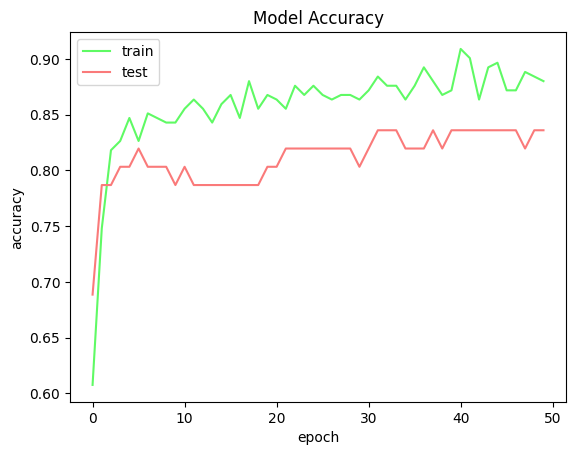

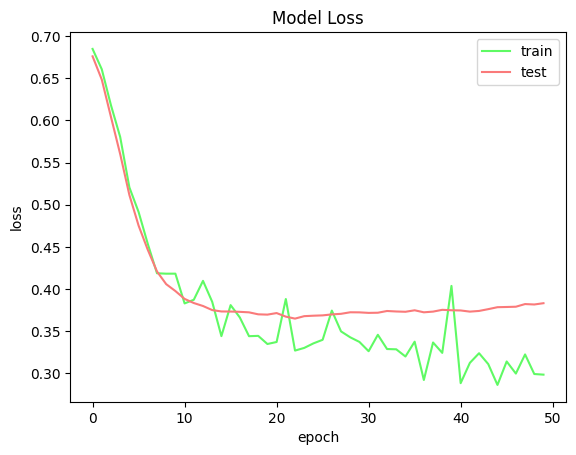

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline
# Model accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

# Model Losss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

In [42]:
# generate classification report using predictions for categorical model
from sklearn.metrics import classification_report, accuracy_score

categorical_pred = np.argmax(model_n.predict(X_test), axis=1)

print('Results for Categorical Model')
print(accuracy_score(y_test, categorical_pred))
print(classification_report(y_test, categorical_pred))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Results for Categorical Model
0.8360655737704918
              precision    recall  f1-score   support

           0       0.91      0.71      0.80        28
           1       0.79      0.94      0.86        33

    accuracy                           0.84        61
   macro avg       0.85      0.83      0.83        61
weighted avg       0.85      0.84      0.83        61



In [43]:
# define a function to build the keras model
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(16, input_dim=12, kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.001), activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(8, kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.001), activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(2, activation='softmax'))
    
    # compile model
    adam = Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model

model = create_model()

C:\Users\aliek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [44]:
# fit the model to the training data
history_not_age=model.fit(X_train_not_age, Y_train, validation_data=(X_test_not_age, Y_test),epochs=50, batch_size=10)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5826 - loss: 0.6872 - val_accuracy: 0.7541 - val_loss: 0.6754
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7316 - loss: 0.6706 - val_accuracy: 0.7869 - val_loss: 0.6410
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7754 - loss: 0.6312 - val_accuracy: 0.8197 - val_loss: 0.5999
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8686 - loss: 0.5718 - val_accuracy: 0.8033 - val_loss: 0.5540
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8699 - loss: 0.5298 - val_accuracy: 0.8197 - val_loss: 0.5077
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8535 - loss: 0.4905 - val_accuracy: 0.8197 - val_loss: 0.4649
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8706 - loss: 0.4385 - val_accuracy: 0.8197 - val_loss: 0.4302
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8455 - loss: 0.4083 - val_accuracy: 0.8197 - val_loss

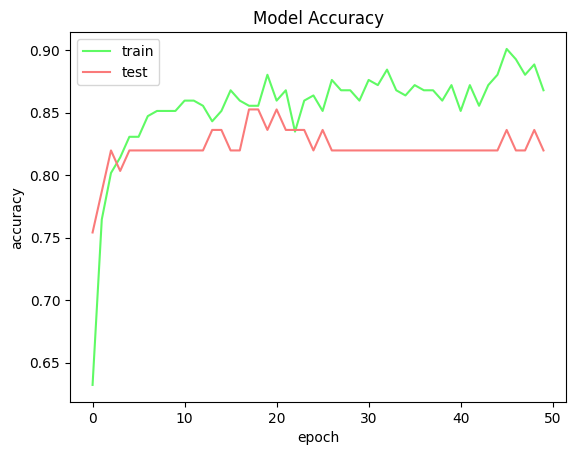

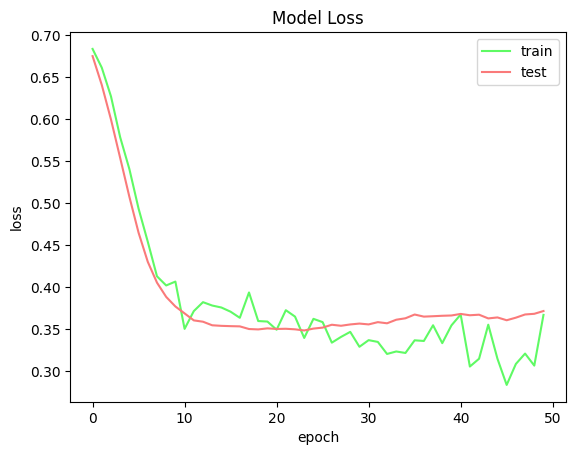

In [45]:
# Model accuracy
plt.plot(history_not_age.history['accuracy'])
plt.plot(history_not_age.history['val_accuracy'])
plt.title('Model Accuracy Without Age')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

# Model Losss
plt.plot(history_not_age.history['loss'])
plt.plot(history_not_age.history['val_loss'])
plt.title('Model Loss Without Age')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

In [46]:
# generate classification report using predictions for categorical model
from sklearn.metrics import classification_report, accuracy_score

categorical_pred = np.argmax(model.predict(X_test_not_age), axis=1)

print('Results for Categorical Model')
print(accuracy_score(y_test, categorical_pred))
print(classification_report(y_test, categorical_pred))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Results for Categorical Model
0.819672131147541
              precision    recall  f1-score   support

           0       0.90      0.68      0.78        28
           1       0.78      0.94      0.85        33

    accuracy                           0.82        61
   macro avg       0.84      0.81      0.81        61
weighted avg       0.83      0.82      0.82        61



In [47]:
history_not_sex=model.fit(X_train_not_sex, Y_train, validation_data=(X_test_not_sex, Y_test),epochs=50, batch_size=10)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8437 - loss: 0.3980 - val_accuracy: 0.7541 - val_loss: 0.4282
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8154 - loss: 0.4018 - val_accuracy: 0.7541 - val_loss: 0.4188
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8436 - loss: 0.3484 - val_accuracy: 0.7541 - val_loss: 0.4135
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8245 - loss: 0.3445 - val_accuracy: 0.7541 - val_loss: 0.4062
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8304 - loss: 0.4095 - val_accuracy: 0.7541 - val_loss: 0.4029
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8647 - loss: 0.3465 - val_accuracy: 0.7705 - val_loss: 0.4020
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8756 - loss: 0.3311 - val_accuracy: 0.7541 - val_loss: 0.3989
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8899 - loss: 0.3604 - val_accuracy: 0.7869 - val_loss:

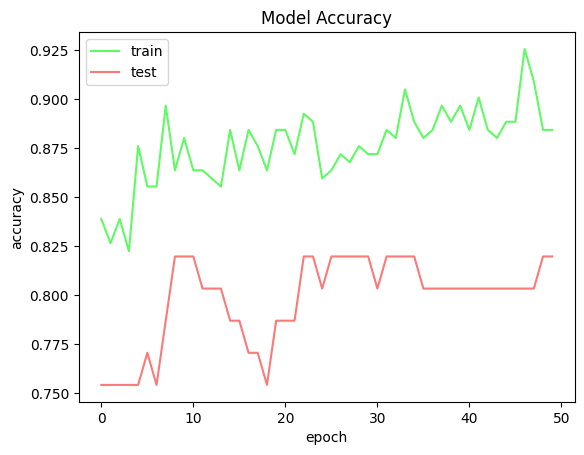

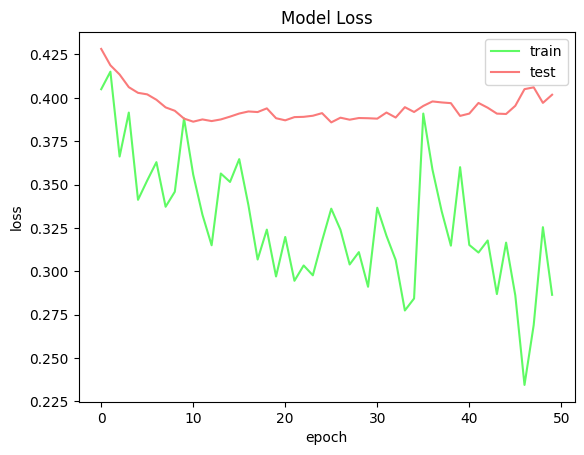

In [48]:
# Model accuracy
plt.plot(history_not_sex.history['accuracy'])
plt.plot(history_not_sex.history['val_accuracy'])
plt.title('Model Accuracy Without Sex')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

# Model Losss
plt.plot(history_not_sex.history['loss'])
plt.plot(history_not_sex.history['val_loss'])
plt.title('Model Loss Without Sex')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

In [49]:
# generate classification report using predictions for categorical model
from sklearn.metrics import classification_report, accuracy_score

categorical_pred = np.argmax(model.predict(X_test_not_sex), axis=1)

print('Results for Categorical Model')
print(accuracy_score(y_test, categorical_pred))
print(classification_report(y_test, categorical_pred))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Results for Categorical Model
0.819672131147541
              precision    recall  f1-score   support

           0       0.95      0.64      0.77        28
           1       0.76      0.97      0.85        33

    accuracy                           0.82        61
   macro avg       0.85      0.81      0.81        61
weighted avg       0.85      0.82      0.81        61



In [50]:
history_not_fbs=model.fit(X_train_not_fbs, Y_train, validation_data=(X_test_not_fbs, Y_test),epochs=50, batch_size=10)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7352 - loss: 0.5602 - val_accuracy: 0.7541 - val_loss: 0.5264
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8118 - loss: 0.4138 - val_accuracy: 0.7541 - val_loss: 0.4844
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8700 - loss: 0.3822 - val_accuracy: 0.7541 - val_loss: 0.4602
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8002 - loss: 0.3935 - val_accuracy: 0.7705 - val_loss: 0.4516
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7985 - loss: 0.4521 - val_accuracy: 0.7541 - val_loss: 0.4438
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8561 - loss: 0.3683 - val_accuracy: 0.7377 - val_loss: 0.4239
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8722 - loss: 0.3428 - val_accuracy: 0.7377 - val_loss: 0.4100
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8036 - loss: 0.3886 - val_accuracy: 0.7377 - val_loss:

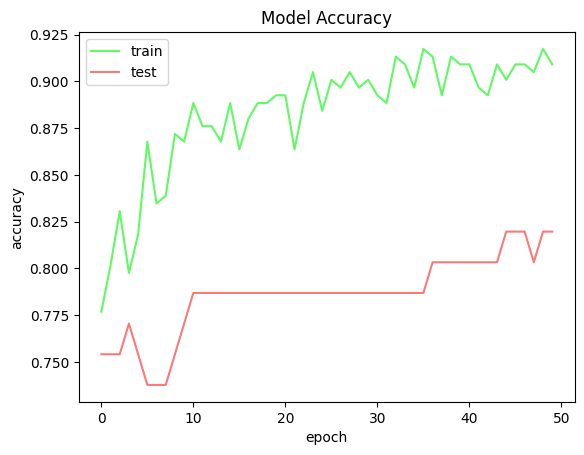

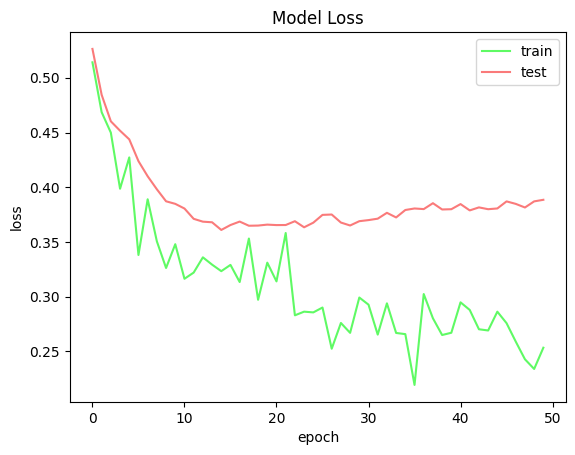

In [51]:
# Model accuracy
plt.plot(history_not_fbs.history['accuracy'])
plt.plot(history_not_fbs.history['val_accuracy'])
plt.title('Model Accuracy Without FBS')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

# Model Losss
plt.plot(history_not_fbs.history['loss'])
plt.plot(history_not_fbs.history['val_loss'])
plt.title('Model Loss Without FBS')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

In [52]:
# generate classification report using predictions for categorical model
from sklearn.metrics import classification_report, accuracy_score

categorical_pred = np.argmax(model.predict(X_test_not_fbs), axis=1)

print('Results for Categorical Model')
print(accuracy_score(y_test, categorical_pred))
print(classification_report(y_test, categorical_pred))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Results for Categorical Model
0.819672131147541
              precision    recall  f1-score   support

           0       0.95      0.64      0.77        28
           1       0.76      0.97      0.85        33

    accuracy                           0.82        61
   macro avg       0.85      0.81      0.81        61
weighted avg       0.85      0.82      0.81        61

